---
# **Natural Language Processing with Disaster Tweets**
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. Problem definition**

Many people shere their thoughts via tweets. Some of the tweets are about disasters like e.g. fire. But not all of them are true. The goal of the project is to alalyze tweets and then to classify if they are about real or fake disatster.

**NLP - Natural Language Processing**

Natural language processing is the field of linguistics, computer science and artificial intelligence. It is the processing of language, words and speech by the computer. In other words, it is a translation between a human language and a computer language. We are going to use NLP to change words into vectors with numbers.

**Neural Networks**

A neural network is a combination of elements called artificial neurons that have at least three layers: input, hidden and output, and there may be many hidden layers. The neurons of the network process information thanks to the fact that their connections are given parameters called weights, which are modified during the operation of the network. Modifying weights is called "learning" the network. We will use neural networks (after using logistic regression) to predict whether the disaster described in the tweet is true or false.



# **2. EDA - Exploratory Data Analysis**

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/tweets/train.csv')
print(data.head().to_string())

   id keyword location                                                                                                                                   text  target
0   1     NaN      NaN                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1
1   4     NaN      NaN                                                                                                 Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected       1
3   6     NaN      NaN                                                                      13,000 people receive #wildfires evacuation orders in California        1
4   7     NaN      NaN                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school        1


In [ ]:
data.shape

(7613, 5)

**How many tweets are real disasters (0) and how many are fake (1)?**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of tweets')

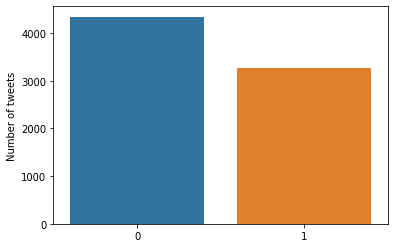

In [ ]:
x=data.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of tweets')

**What is the number of words in tweets?**

In [ ]:
data['text'].apply(lambda x: len(str(x).split()))

0       13
1        7
2       22
3        8
4       16
        ..
7608    11
7609    20
7610     8
7611    19
7612    13
Name: text, Length: 7613, dtype: int64

# **3. Data cleaning**

In [ ]:
def clean(text):
    clean_tekst = re.compile(r'!\"\#\$\%\&\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~https?://\S+|www\.\S\+')
    return clean_tekst.sub(r'',text)

In [ ]:
data['text']=data['text'].apply(lambda x : clean(x))

# **4. Logistic regression**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.target, test_size=0.1, random_state=1)

In [ ]:
X_train.head(5)

In [ ]:
#TF – term frequency, IDF – inverse document frequency

vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                            stop_words= 'english',ngram_range=(1,3),dtype=np.float32)

In [ ]:
X_train_vect = vect_word.fit_transform(X_train)
X_test_vect = vect_word.transform(X_test)

In [ ]:
model = LogisticRegression(random_state = 1)
model.fit(X_train_vect, y_train)

LogisticRegression(random_state=1)

In [ ]:
print(confusion_matrix(y_test, model.predict(X_test_vect)))

[[397  41]
 [110 214]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


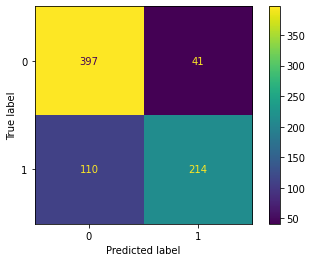

In [ ]:
plot_confusion_matrix(model, X_test_vect, y_test)

As we can see the confusion matrix is not satisfying yet, False
Negative and False Positive are high values.

In [ ]:
print(classification_report(y_test, model.predict(X_test_vect)))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       438
           1       0.84      0.66      0.74       324

    accuracy                           0.80       762
   macro avg       0.81      0.78      0.79       762
weighted avg       0.81      0.80      0.80       762



Text(0.5, 1.0, 'Reciever Operating Characteristic')

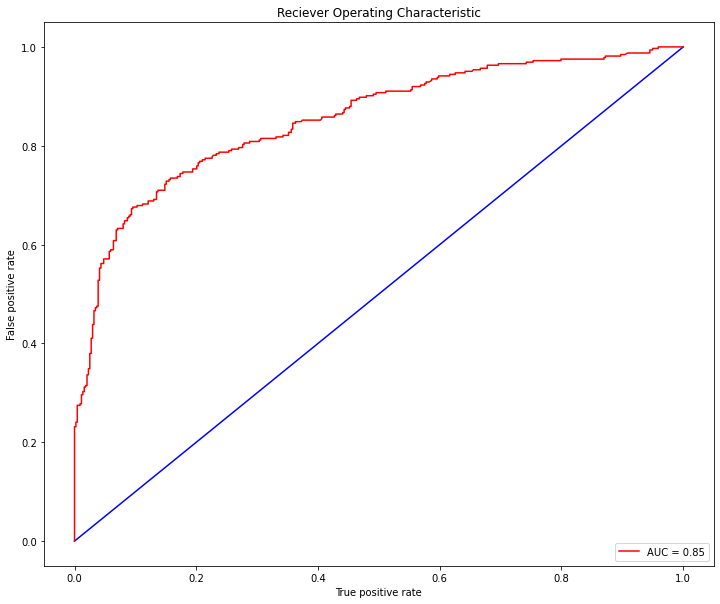

In [ ]:
frp,trp,thres = roc_curve(y_test,model.predict_proba(X_test_vect)[:,1])
auc_val = auc(frp,trp)
plt.figure(figsize=(12,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

# **5. Neural Network CNN**

In [51]:
N = 1000
tokenizer = Tokenizer(num_words=N, lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train_mat = tokenizer.texts_to_sequences(X_train)
X_train_mat = pad_sequences(X_train_mat, maxlen=100)

model = Sequential()
model.add(Embedding(N, 128, input_length=X_train_mat.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          128000    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 210,177
Trainable params: 210,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 10
batch_size = 64
history = model.fit(X_train_mat, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
97/97 [==============================] - 11s 105ms/step - loss: 0.5767 - binary_accuracy: 0.7006 - val_loss: 0.4558 - val_binary_accuracy: 0.7988
Epoch 2/10
97/97 [==============================] - 9s 94ms/step - loss: 0.4093 - binary_accuracy: 0.8221 - val_loss: 0.4512 - val_binary_accuracy: 0.7915
Epoch 3/10
97/97 [==============================] - 15s 160ms/step - loss: 0.3549 - binary_accuracy: 0.8504 - val_loss: 0.4697 - val_binary_accuracy: 0.7988
Epoch 4/10
97/97 [==============================] - 10s 102ms/step - loss: 0.3138 - binary_accuracy: 0.8723 - val_loss: 0.4829 - val_binary_accuracy: 0.7930
Epoch 5/10
97/97 [==============================] - 11s 112ms/step - loss: 0.2720 - binary_accuracy: 0.8954 - val_loss: 0.5026 - val_binary_accuracy: 0.7901
Epoch 6/10
97/97 [==============================] - 16s 165ms/step - loss: 0.2316 - binary_accuracy: 0.9161 - val_loss: 0.5374 - val_binary_accuracy: 0.7843
Epoch 7/10
97/97 [==============================] - 10s 101m

In [ ]:
#Notebooks used:
#https://www.kaggle.com/faressayah/natural-language-processing-nlp-for-beginners
#https://www.kaggle.com/dmikar/cnn-and-lstm
#https://www.kaggle.com/ahlemloulou/cnn-for-disaster-classification
#https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook
#https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove
#https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook